# Surabaya Tourism Destination Recommendation System

- Nama  : Labiba Adinda Zahwana
- Email : labibaadinda

# Deskripsi Proyek

Proyek ini bertujuan membangun sistem rekomendasi destinasi wisata di Kota Surabaya yang dapat membantu pengguna dalam menemukan tempat wisata sesuai preferensi dan kebiasaan mereka.
Dataset yang digunakan pada proyek ini diperoleh dari public repository Kaggle yang dapat diakses melalui tautan berikut: [Indonesian Tourism Destination](https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination/code?datasetId=1481754&sortBy=voteCount).
<br>
Sistem ini menggunakan dua pendekatan utama:

1. **Content-Based Filtering**
   > Sistem memanfaatkan deskripsi dan kategori wisata untuk memberikan rekomendasi tempat wisata yang mirip secara konten dengan tempat yang sudah disukai pengguna. Proses ini melibatkan praproses teks menggunakan stemming dan penghilangan kata umum (stopword) Bahasa Indonesia, serta representasi fitur menggunakan TF-IDF dan perhitungan similarity cosine antar objek wisata.

2. **Collaborative Filtering dengan Deep Learning**
   > Menggunakan data rating dari pengguna terhadap destinasi wisata, dibuat model neural network dengan embedding untuk user dan tempat wisata guna mempelajari pola interaksi pengguna. Model ini memprediksi rating untuk tempat yang belum dikunjungi pengguna dan merekomendasikan tempat dengan prediksi rating tertinggi secara personal.




## 1. Import Library
Import library atau package yang akan digunakan pada project ini

In [149]:
!pip install Sastrawi

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

import sklearn.feature_extraction.text as text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import linear_kernel

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

Penjelasan library yang digunakan :
- pandas, numpy: Manipulasi data.

- matplotlib, seaborn, plotly.express: Visualisasi data.

- sklearn (TF-IDF, cosine similarity): Untuk content-based filtering.

- Sastrawi: Bahasa Indonesia stemmer dan stopword remover (praproses teks).

- tensorflow.keras: Membuat model deep learning untuk collaborative filtering.



## 2. Data Loading

In [151]:
urls = [
    'https://raw.githubusercontent.com/labibaadinda/surabaya-tourism-destination-recommendation-system/main/dataset/package_tourism.csv',
    'https://raw.githubusercontent.com/labibaadinda/surabaya-tourism-destination-recommendation-system/main/dataset/tourism_rating.csv',
    'https://raw.githubusercontent.com/labibaadinda/surabaya-tourism-destination-recommendation-system/main/dataset/tourism_with_id.csv',
    'https://raw.githubusercontent.com/labibaadinda/surabaya-tourism-destination-recommendation-system/main/dataset/user.csv'
]

import pandas as pd

dataframes = [pd.read_csv(url) for url in urls]


In [152]:
data_tourism_rating = pd.read_csv(urls[1])
data_tourism_with_id = pd.read_csv(urls[2])
data_user = pd.read_csv(urls[3])

Data diambil dari URL (CSV online di Github Repository saya) ke dalam DataFrame pandas:

- package_tourism.csv: Paket wisata (tidak digunakan langsung di sini).

- tourism_rating.csv: Data rating pengguna ke tempat wisata.

- tourism_with_id.csv: Data tempat wisata dengan ID.

- user.csv: Data pengguna.

## 3. Data Understanding

- Menampilkan sekilas data (head()).

- Memeriksa ukuran data, tipe data, nilai null.

- Mengecek data duplikat dan menghapusnya jika ada (penting agar data bersih).



In [153]:
data_tourism_rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [154]:
data_tourism_with_id.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [155]:
data_user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [156]:
print(f"Jumlah rating tourism: {data_tourism_rating.shape[0]}")
print(f"Jumlah tourism with id: {data_tourism_with_id.shape[0]}")
print(f"Jumlah users: {data_user.shape[0]}")

Jumlah rating tourism: 10000
Jumlah tourism with id: 437
Jumlah users: 300


In [157]:
data_tourism_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [158]:
data_tourism_with_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [159]:
data_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


cek null di masing-masing dataframe

In [160]:
data_tourism_rating.isnull().sum().sort_values(ascending=False)

,0
User_Id,0
Place_Id,0
Place_Ratings,0


In [161]:
data_tourism_with_id.isnull().sum().sort_values(ascending=False)

,0
Unnamed: 11,437
Time_Minutes,232
Description,0
Place_Name,0
Place_Id,0
City,0
Category,0
Rating,0
Price,0
Coordinate,0


In [162]:
data_user.isnull().sum().sort_values(ascending=False)

,0
User_Id,0
Location,0
Age,0


In [163]:
print(data_tourism_with_id.columns)

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11',
       'Unnamed: 12'],
      dtype='object')


In [164]:
data_tourism_with_id['Category'].unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

In [165]:
data_tourism_with_id.duplicated().sum()

np.int64(0)

In [166]:
data_tourism_rating.duplicated().sum()

np.int64(79)

In [167]:
data_user.duplicated().sum()

np.int64(0)

In [168]:
data_tourism_rating.duplicated().sum()

np.int64(79)

berdasarkan data understanding terdapat
 :
 - terdapat duplicated di data_tourism_rating, ini dihapus duplicated nya di bagian keempT data preprocessing (tepatnya di 4. 2. Data tourism rating)
 - terdapat null di data frame data_tourism_with_id dengan kolom (nantinya kolom tsb akan di hapus karena tidak digunakan untuk proses lebih lanjutnya)
* Unnamed: 11	sebanyak 437
* Time_Minutes sebanyak 232


## 4. Data Preprocessing

### 4. 1. Data tourism with id

In [169]:
# drop kolom yang tidak terpakai
data_tourism_with_id.drop(['Rating','Time_Minutes','Coordinate','Lat','Long','Unnamed: 11','Unnamed: 12'],axis=1,inplace=True)
data_tourism_with_id

,Place_Id,Place_Name,Description,Category,City,Price
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000
...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0


Ubah data agar hanya **Kota Surabaya** saja

In [170]:
place = data_tourism_with_id[data_tourism_with_id['City'] == 'Surabaya']

In [171]:
place.head()

,Place_Id,Place_Name,Description,Category,City,Price
391,392,Ekowisata Mangrove Wonorejo,Hutan Wisata Mangrove Surabaya merupakan wisat...,Cagar Alam,Surabaya,0
392,393,Taman Harmoni Keputih,Tempat tersebut ialah Taman Hatmoni Keputih Su...,Cagar Alam,Surabaya,0
393,394,Air Mancur Menari,Jembatan Kenjeran dengan air mancur menarinya ...,Taman Hiburan,Surabaya,35000
394,395,Taman Prestasi,Taman Prestasi Surabaya merupakan salah satu t...,Taman Hiburan,Surabaya,0
395,396,Monumen Kapal Selam,"Monumen Kapal Selam, atau disingkat Monkasel, ...",Budaya,Surabaya,15000


data preprocessing pada 4.1 data tourism with id dilakukan **filtering** :
* Drop kolom yang tidak relevan untuk analisis.

* Fokus hanya pada wisata di Kota Surabaya dengan filter City == 'Surabaya'.

### 4. 2. Data tourism rating

**menghapus** data tourism rating yang duplikat

In [172]:
data_tourism_rating.drop_duplicates(inplace=True)

In [173]:
data_tourism_rating.duplicated().sum()

np.int64(0)

In [174]:
# Merubah data rating agar hanya berisi rating pada tempat wisata dari Surabaya
rating = pd.merge(data_tourism_rating, place[['Place_Id']], on='Place_Id', how='right')
rating.head()

,User_Id,Place_Id,Place_Ratings
0,25,392,4
1,44,392,3
2,108,392,5
3,119,392,3
4,125,392,5


In [175]:
# Melihat ukuran dataset rating untuk Kota Surabaya
rating.shape

(1038, 3)

In [176]:
# gabungin antara rating dengan place (yang sudah difilter surabaya aja)
data_rekomendasi = pd.merge(rating.groupby('Place_Id')['Place_Ratings'].mean(),place,on='Place_Id')
data_rekomendasi

,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price
0,392,3.312500,Ekowisata Mangrove Wonorejo,Hutan Wisata Mangrove Surabaya merupakan wisat...,Cagar Alam,Surabaya,0
1,393,3.047619,Taman Harmoni Keputih,Tempat tersebut ialah Taman Hatmoni Keputih Su...,Cagar Alam,Surabaya,0
2,394,2.769231,Air Mancur Menari,Jembatan Kenjeran dengan air mancur menarinya ...,Taman Hiburan,Surabaya,35000
3,395,3.304348,Taman Prestasi,Taman Prestasi Surabaya merupakan salah satu t...,Taman Hiburan,Surabaya,0
4,396,3.368421,Monumen Kapal Selam,"Monumen Kapal Selam, atau disingkat Monkasel, ...",Budaya,Surabaya,15000
5,397,3.095238,Taman Kunang-Kunang,Taman Kunang – Kunang di Surabaya ini mempunya...,Taman Hiburan,Surabaya,0
6,398,3.074074,Taman Buah Surabaya,Wisata Taman Buah Undaan di Surabaya adalah sa...,Taman Hiburan,Surabaya,0
7,399,3.588235,Taman Pelangi,Kalau pelangi biasanya ada di siang hari pasca...,Taman Hiburan,Surabaya,0
8,400,2.521739,Hutan Bambu Keputih,Surabaya menjadi kota metropolitan kedua setel...,Cagar Alam,Surabaya,0
9,401,3.576923,Taman Keputran,"Ntah, mengapa nama taman ini disebut dengan ta...",Taman Hiburan,Surabaya,0


**Pada 4.2. Data tourism rating dilakukan preprocessing dengan cara:**
* Menghapus data tourism rating yang duplikat
* **Memfilter data rating** agar hanya berisi rating dari tempat-tempat wisata yang ada di Surabaya, dengan cara melakukan *merge* antara `data_tourism_rating` dan data `place` (yang sudah difilter hanya tempat wisata di Surabaya) berdasarkan `Place_Id`. Metode penggabungan menggunakan `how='right'` agar hasilnya hanya mencakup tempat wisata Surabaya.

* **Menghitung rata-rata rating** untuk tiap tempat wisata di Surabaya dengan mengelompokkan data rating berdasarkan `Place_Id` dan mengambil nilai rata-rata pada kolom `Place_Ratings`.

* **Menggabungkan hasil rata-rata rating** tersebut kembali dengan data `place` agar memperoleh data lengkap setiap tempat wisata beserta rata-rata ratingnya.


### 4. 3. Data User

In [177]:
data_user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [178]:
# Merubah data user agar hanya berisi user yang pernah mengunjungi wisata di Surabaya
user = pd.merge(data_user, rating[['User_Id']], on='User_Id', how='right')
user.head()

,User_Id,Location,Age
0,25,"Lampung, Sumatera Selatan",40
1,44,"Subang, Jawa Barat",21
2,108,"Klaten, Jawa Tengah",33
3,119,"Purwakarat, Jawa Barat",25
4,125,"Karawang, Jawa Barat",24


In [179]:
# Melihat dataset user yang pernah memberi rating pada wisata di Surabaya

user.shape

(1038, 3)

Pada tahap preprocessing di data user dilakukan penyaringan data :
> Memfilter data user agar hanya mencakup pengguna yang pernah memberi rating destinasi wisata di Surabaya dengan menggabungkan data user dan data rating Surabaya berdasarkan User_Id.

## 5. Exploratory Data Analysis (EDA)

In [180]:
# buat variable / data frame yang isi nya lokasi dengan jumlah rating terbanyak
top_10 = rating['Place_Id'].value_counts().sort_values(ascending=False).reset_index()[0:10]
top_10 = pd.merge(top_10, data_tourism_with_id[['Place_Id', 'Place_Name']], on='Place_Id', how='left')
top_10

,Place_Id,count,Place_Name
0,437,37,Gereja Perawan Maria Tak Berdosa Surabaya
1,402,32,Food Junction Grand Pakuwon
2,430,32,Atlantis Land Surabaya
3,416,30,Keraton Surabaya
4,406,29,Kebun Bibit Wonorejo
5,427,28,Patung Buddha Empat Rupa
6,405,27,Surabaya North Quay
7,398,27,Taman Buah Surabaya
8,417,26,Klenteng Sanggar Agung
9,413,26,Museum TNI AL Loka Jala Crana


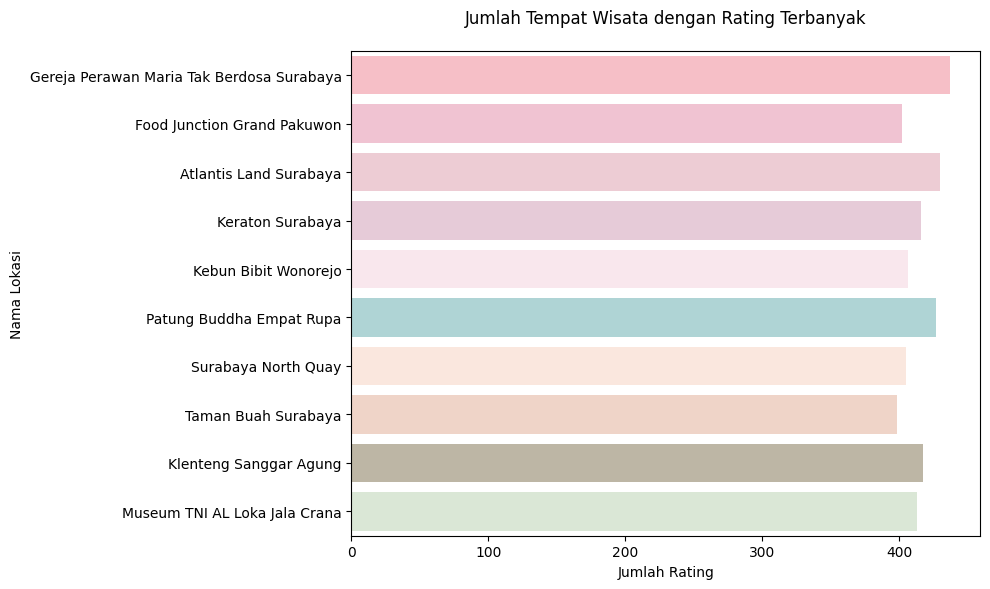

In [181]:
# Membuat visualisasi wisata dengan jumlah rating terbanyak
plt.figure(figsize=(10,6))

colors = sns.color_palette([
    "#ffb6c1",  # light pink
    "#f8bbd0",  # pastel pink
    "#f3c6d1",  # soft rose
    "#eac7d8",  # dusty pink
    "#fce4ec",  # very light pink
    "#a8dadc",  # pastel blue mint (pelengkap)
    "#ffe5d9",  # pastel peach (pelengkap)
    "#f6d1c1",  # pastel coral (pelengkap)
    "#c1b7a1",  # beige soft (pelengkap)
    "#d9ead3"   # pastel green (pelengkap)
])


sns.barplot(
    x='Place_Id',
    y='Place_Name',
    data=top_10,
    palette=colors
)

plt.title('Jumlah Tempat Wisata dengan Rating Terbanyak', pad=20)
plt.ylabel('Nama Lokasi')
plt.xlabel('Jumlah Rating')
plt.tight_layout()
plt.show()

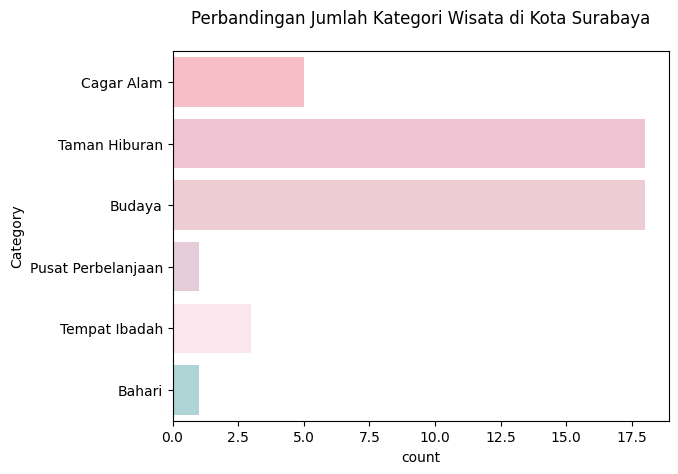

In [182]:
# Membuat visualisasi jumlah kategori wisata di Kota Surabaya
colors = sns.color_palette([
    "#ffb6c1",  # light pink
    "#f8bbd0",  # pastel pink
    "#f3c6d1",  # soft rose
    "#eac7d8",  # dusty pink
    "#fce4ec",  # very light pink
    "#a8dadc",  # pastel blue mint (pelengkap)
    "#ffe5d9",  # pastel peach (pelengkap)
    "#f6d1c1",  # pastel coral (pelengkap)
    "#c1b7a1",  # beige soft (pelengkap)
    "#d9ead3"   # pastel green (pelengkap)
])

sns.countplot(
    y='Category',
    data=place,
    palette= colors
)

plt.title('Perbandingan Jumlah Kategori Wisata di Kota Surabaya', pad=20)
plt.show()

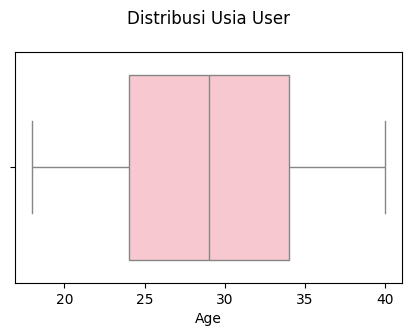

In [183]:
plt.figure(figsize=(5,3))
sns.boxplot(x='Age', data=user, color='pink')
plt.title('Distribusi Usia User', pad=20)
plt.show()

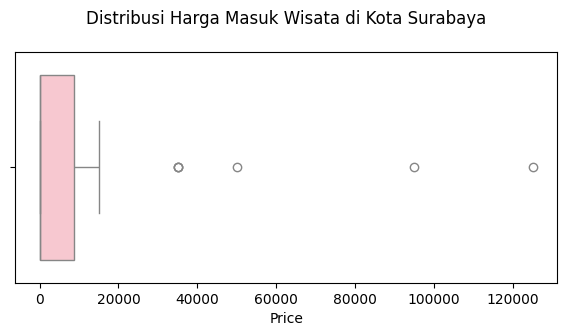

In [184]:
# Membuat visualisasi distribusi harga masuk tempat wisata

plt.figure(figsize=(7,3))
sns.boxplot(x=place['Price'], color='pink')
plt.title('Distribusi Harga Masuk Wisata di Kota Surabaya', pad=20)
plt.show()

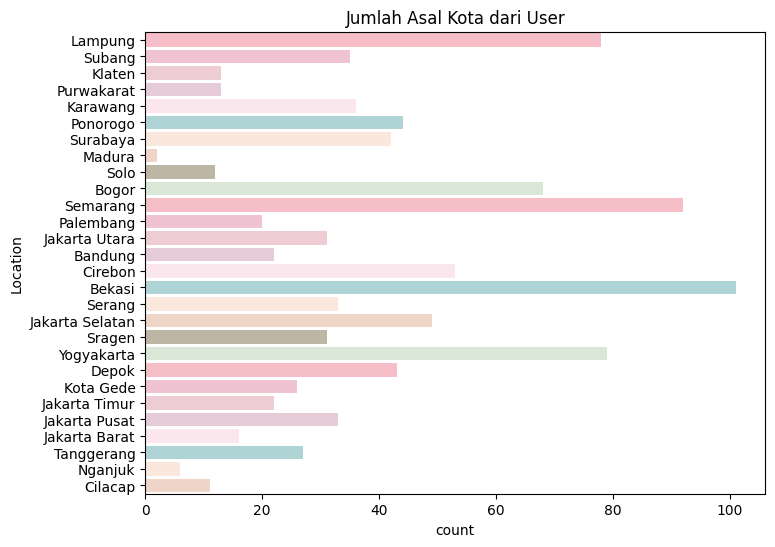

In [185]:
# Memfilter asal kota dari user
# Buat palette warna pinkish pastel (custom)
colors = sns.color_palette([
    "#ffb6c1",  # light pink
    "#f8bbd0",  # pastel pink
    "#f3c6d1",  # soft rose
    "#eac7d8",  # dusty pink
    "#fce4ec",  # very light pink
    "#a8dadc",  # pastel blue mint (pelengkap)
    "#ffe5d9",  # pastel peach (pelengkap)
    "#f6d1c1",  # pastel coral (pelengkap)
    "#c1b7a1",  # beige soft (pelengkap)
    "#d9ead3"   # pastel green (pelengkap)
])


askot = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8,6))
sns.countplot(
    y=askot,
    data=user,
    palette=colors
)
plt.title('Jumlah Asal Kota dari User')
plt.show()

Pada EDA ini telah dilakukan :
- Visualisasi top 10 tempat wisata berdasarkan jumlah rating.

- Visualisasi kategori wisata yang ada di Surabaya.

- Distribusi usia pengguna.

- Distribusi harga tiket masuk.

- Visualisasi asal kota pengguna.

Hasil **analisis** EDA :
- tempat paling banyak pengunjung di Surabaya `Gereja Perawan Maria Tak Berdosa Surabaya`.
- jumlah kategori wisata di Kota Surabaya terbanyak yaitu `budaya` dan `taman hiburan`.
- distribusi usia sekitar 23-34 tahun.
- distribusi Harga Masuk Wisata di Kota Surabaya sekitar 0-20000, namun ada beberapa outlier / harga diluar range tsb.
- asal kota dari User terbanyak ada di Kota `Bekasi`.

## 6. Data Preparation

**Buat fungsi preprocessing data**

In [186]:
stem = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

def preprocessing(data):
  data = data.lower()
  data = stem.stem(data)
  data = stopword.remove(data)
  return data

In [187]:
data_content_based_filtering = data_rekomendasi.copy()
data_content_based_filtering['Tags'] = data_content_based_filtering['Description'] + " " + data_content_based_filtering['Category']
data_content_based_filtering.drop(['Price','Place_Ratings','Description','Category','City'],axis=1,inplace=True)
data_content_based_filtering

,Place_Id,Place_Name,Tags
0,392,Ekowisata Mangrove Wonorejo,Hutan Wisata Mangrove Surabaya merupakan wisat...
1,393,Taman Harmoni Keputih,Tempat tersebut ialah Taman Hatmoni Keputih Su...
2,394,Air Mancur Menari,Jembatan Kenjeran dengan air mancur menarinya ...
3,395,Taman Prestasi,Taman Prestasi Surabaya merupakan salah satu t...
4,396,Monumen Kapal Selam,"Monumen Kapal Selam, atau disingkat Monkasel, ..."
5,397,Taman Kunang-Kunang,Taman Kunang – Kunang di Surabaya ini mempunya...
6,398,Taman Buah Surabaya,Wisata Taman Buah Undaan di Surabaya adalah sa...
7,399,Taman Pelangi,Kalau pelangi biasanya ada di siang hari pasca...
8,400,Hutan Bambu Keputih,Surabaya menjadi kota metropolitan kedua setel...
9,401,Taman Keputran,"Ntah, mengapa nama taman ini disebut dengan ta..."


**Melakukan Encoding dengan TF-IDF**

In [188]:
# buat variable tf untuk mempermudah pemanggilan method TfidfVectorizer
tv = TfidfVectorizer(max_features=5000)

In [189]:
vectors = tv.fit_transform(data_content_based_filtering.Tags).toarray()
vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Ekstraksi Fitur Teks**
> Menggunakan TF-IDF Vectorizer (Term Frequency - Inverse Document Frequency) yang mengubah teks menjadi representasi numerik berbentuk vektor.
- TF-IDF membantu menimbang kata-kata penting yang membedakan satu tempat wisata dengan yang lain.
- Batasi fitur maksimal (max_features=5000) agar model efisien dan tidak terlalu rumit.

## 7. Model Development

### 7. 1. Content Based Filtering

Content-Based Filtering merekomendasikan item (tempat wisata) berdasarkan kemiripan konten (fitur deskriptif) dari item yang sudah disukai atau pernah dikunjungi oleh pengguna.



In [190]:
similarity = cosine_similarity(vectors)
similarity[0][1:10]

array([0.09451203, 0.09892528, 0.05760062, 0.05061528, 0.04897005,
       0.21339319, 0.0502913 , 0.16614577, 0.06611817])

**Menghitung Similarity**
> Dengan vektor TF-IDF dari semua tempat wisata, dihitung cosine similarity antar tempat wisata.
- Cosine similarity mengukur seberapa mirip dua destinasi berdasarkan konten teksnya, dengan nilai antara 0 (tidak mirip) sampai 1 (sangat mirip).

In [191]:
def recommend_by_content_based_filtering(nama_tempat):
    nama_tempat_index = data_content_based_filtering[data_content_based_filtering['Place_Name']==nama_tempat].index[0]
    distancess = similarity[nama_tempat_index]
    nama_tempat_list = sorted(list(enumerate(distancess)),key=lambda x: x[1],reverse=True)[1:10]

    recommended_nama_tempats = []
    for i in nama_tempat_list:
        recommended_nama_tempats.append([data_content_based_filtering.iloc[i[0]].Place_Name]+[i[1]])
        # print(nama_tempats.iloc[i[0]].original_title)

    return recommended_nama_tempats

In [192]:
data_content_based_filtering['Place_Name'].unique()

array(['Ekowisata Mangrove Wonorejo', 'Taman Harmoni Keputih',
       'Air Mancur Menari', 'Taman Prestasi', 'Monumen Kapal Selam',
       'Taman Kunang-Kunang', 'Taman Buah Surabaya', 'Taman Pelangi',
       'Hutan Bambu Keputih', 'Taman Keputran',
       'Food Junction Grand Pakuwon', 'Taman Barunawati', 'Kenjeran Park',
       'Surabaya North Quay', 'Kebun Bibit Wonorejo',
       'Taman Ekspresi Dan Perpustakaan', 'Kebun Binatang Surabaya',
       'Rumah Batik', 'Ciputra Waterpark', 'Masjid Muhammad Cheng Hoo',
       'Masjid Nasional Al-Akbar', 'Museum TNI AL Loka Jala Crana',
       'Jembatan Merah', 'Museum De Javasche Bank', 'Keraton Surabaya',
       'Klenteng Sanggar Agung', 'Museum Sepuluh Nopember Kota Surabaya',
       'Monumen Tugu Pahlawan', 'Surabaya Museum (Gedung Siola)',
       'Museum Kesehatan Dr. Adhyatma', 'Monumen Jalesveva Jayamahe',
       'Patung Sura dan Buaya', 'Pantai Ria Kenjeran',
       'Waterpark Kenjeran Surabaya', 'Balai Kota Surabaya',
       'Patung

In [193]:
# tes fungsi content based filtering
recommend_by_content_based_filtering('Taman Bungkul')

[['Taman Mundu', np.float64(0.3617191846974404)],
 ['Taman Barunawati', np.float64(0.26497437649888883)],
 ['Taman Flora Bratang Surabaya', np.float64(0.2599244372355745)],
 ['Taman Prestasi', np.float64(0.25814308461436775)],
 ['Taman Keputran', np.float64(0.23392967976541537)],
 ['Taman Buah Surabaya', np.float64(0.22751244458590045)],
 ['Air Mancur Menari', np.float64(0.20773080679276149)],
 ['Taman Hiburan Rakyat', np.float64(0.2026259592565798)],
 ['Taman Pelangi', np.float64(0.1865657473009239)]]

telah **berhasil** membuat rekomendasi berbasis content filtering

**Rekomendasi  content based filtering**
> Saat user memilih atau menyukai suatu destinasi, sistem akan merekomendasikan destinasi lain yang memiliki nilai similarity tinggi dengan destinasi tersebut.
- Misalnya, jika user suka “Taman Bungkul,” sistem akan merekomendasikan tempat-tempat yang deskripsi dan kategorinya mirip dengan Taman Bungkul.

### 7. 2.  Collaborative Filtering

*Collaborative Filtering* (CF) merekomendasikan item (tempat wisata) kepada pengguna berdasarkan pola interaksi atau preferensi pengguna lain yang serupa. Intinya, “pengguna dengan selera mirip biasanya menyukai tempat yang sama.”

In [194]:
data_collaborative_filtering = rating.copy()
data_collaborative_filtering

,User_Id,Place_Id,Place_Ratings
0,25,392,4
1,44,392,3
2,108,392,5
3,119,392,3
4,125,392,5
...,...,...,...
1033,284,437,5
1034,288,437,1
1035,288,437,4
1036,297,437,4


In [195]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = data_collaborative_filtering['User_Id'].unique().tolist()
print(f'Jumlah user: {len(user_ids)} (ID dari 1 hingga {user_ids[-1]})')

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print(f'user_to_user_encoded: {user_to_user_encoded}')

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print(f'user_encoded_to_user: {user_encoded_to_user}')

Jumlah user: 293 (ID dari 1 hingga 290)
user_to_user_encoded: {25: 0, 44: 1, 108: 2, 119: 3, 125: 4, 132: 5, 133: 6, 135: 7, 151: 8, 179: 9, 182: 10, 224: 11, 232: 12, 251: 13, 297: 14, 298: 15, 1: 16, 6: 17, 8: 18, 19: 19, 27: 20, 59: 21, 69: 22, 73: 23, 82: 24, 104: 25, 120: 26, 131: 27, 137: 28, 174: 29, 180: 30, 184: 31, 255: 32, 261: 33, 271: 34, 43: 35, 65: 36, 83: 37, 97: 38, 99: 39, 149: 40, 154: 41, 159: 42, 188: 43, 210: 44, 217: 45, 267: 46, 286: 47, 5: 48, 35: 49, 46: 50, 49: 51, 79: 52, 106: 53, 129: 54, 178: 55, 193: 56, 209: 57, 216: 58, 220: 59, 237: 60, 256: 61, 262: 62, 14: 63, 37: 64, 41: 65, 68: 66, 121: 67, 128: 68, 155: 69, 175: 70, 176: 71, 203: 72, 226: 73, 230: 74, 235: 75, 265: 76, 272: 77, 28: 78, 29: 79, 31: 80, 40: 81, 74: 82, 140: 83, 202: 84, 258: 85, 268: 86, 276: 87, 287: 88, 291: 89, 300: 90, 13: 91, 17: 92, 23: 93, 53: 94, 58: 95, 85: 96, 102: 97, 160: 98, 166: 99, 170: 100, 190: 101, 191: 102, 196: 103, 198: 104, 257: 105, 259: 106, 285: 107, 18: 108

In [196]:
# Mengubah placeID menjadi list tanpa nilai yang sama
resto_ids = data_collaborative_filtering['Place_Id'].unique().tolist()

# Melakukan proses encoding placeID
resto_to_resto_encoded = {x: i for i, x in enumerate(resto_ids)}

# Melakukan proses encoding angka ke placeID
resto_encoded_to_resto = {i: x for i, x in enumerate(resto_ids)}

In [197]:
# Mapping userID ke dataframe user
data_collaborative_filtering['user'] = data_collaborative_filtering['User_Id'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
data_collaborative_filtering['resto'] = data_collaborative_filtering['Place_Id'].map(resto_to_resto_encoded)

**Data Interaksi**
> Menggunakan data rating pengguna terhadap destinasi wisata (User_Id, Place_Id, Place_Ratings).
- Rating ini menunjukkan seberapa suka user terhadap suatu tempat.

**Encoding User dan Item**
> User dan tempat wisata diubah dari ID asli menjadi indeks numerik (misal User_Id 101 → indeks 0, dst).
- Ini penting agar bisa dipakai sebagai input embedding pada model neural network.

In [198]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah resto
num_resto = len(resto_encoded_to_resto)
print(num_resto)

# Mengubah rating menjadi nilai float
data_collaborative_filtering['Place_Ratings'] = data_collaborative_filtering['Place_Ratings'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(data_collaborative_filtering['Place_Ratings'])

# Nilai maksimal rating
max_rating = max(data_collaborative_filtering['Place_Ratings'])

print('Number of User: {}, Number of Resto: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_resto, min_rating, max_rating
))

293
46
Number of User: 293, Number of Resto: 46, Min Rating: 1.0, Max Rating: 5.0


In [199]:
data_collaborative_filtering = data_collaborative_filtering.sample(frac=1, random_state=42)
data_collaborative_filtering

,User_Id,Place_Id,Place_Ratings,user,resto
199,209,401,4.0,57,9
917,32,433,3.0,152,41
536,243,416,5.0,189,24
210,32,402,5.0,152,10
305,17,406,5.0,92,14
...,...,...,...,...,...
87,262,396,3.0,62,4
330,2,407,5.0,199,15
466,208,413,1.0,216,21
121,74,398,3.0,82,6


In [200]:
x = data_collaborative_filtering[['user', 'resto']].values

# Membuat variabel y untuk membuat rating dari hasil
y = data_collaborative_filtering['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * data_collaborative_filtering.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 57   9]
 [152  41]
 [189  24]
 ...
 [216  21]
 [ 82   6]
 [ 40  38]] [0.75 0.5  1.   ... 0.   0.5  0.75]


**Modeling**

In [201]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2)

    x = dot_user_resto + user_bias + resto_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [202]:
model = RecommenderNet(num_users, num_resto, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [203]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.7037 - root_mean_squared_error: 0.3448 - val_loss: 0.7003 - val_root_mean_squared_error: 0.3624
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6966 - root_mean_squared_error: 0.3416 - val_loss: 0.7010 - val_root_mean_squared_error: 0.3629
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6988 - root_mean_squared_error: 0.3486 - val_loss: 0.7036 - val_root_mean_squared_error: 0.3645
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6875 - root_mean_squared_error: 0.3416 - val_loss: 0.7045 - val_root_mean_squared_error: 0.3652
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6747 - root_mean_squared_error: 0.3317 - val_loss: 0.7058 - val_root_mean_squared_error: 0.3662
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6719 - root_mean_squared_error: 0.3255 - val_loss: 0.7053 - val_root_mean_squared_error: 0.3658
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 

**Model Neural Network dengan Embedding**
- Dibangun model RecommenderNet dengan dua embedding layer: satu untuk user dan satu untuk tempat wisata.
- Embedding ini memetakan user dan tempat ke dalam ruang vektor berdimensi rendah yang merepresentasikan karakteristik dan preferensi.
- Model mempelajari interaksi antara user dan tempat melalui operasi dot product dari embedding yang dipelajari.

**Training Model**
- Model dilatih memprediksi rating pengguna pada tempat wisata tertentu berdasarkan embedding.
- Fungsi loss yang dipakai adalah binary crossentropy, dengan metrik evaluasi Root Mean Squared Error (RMSE).

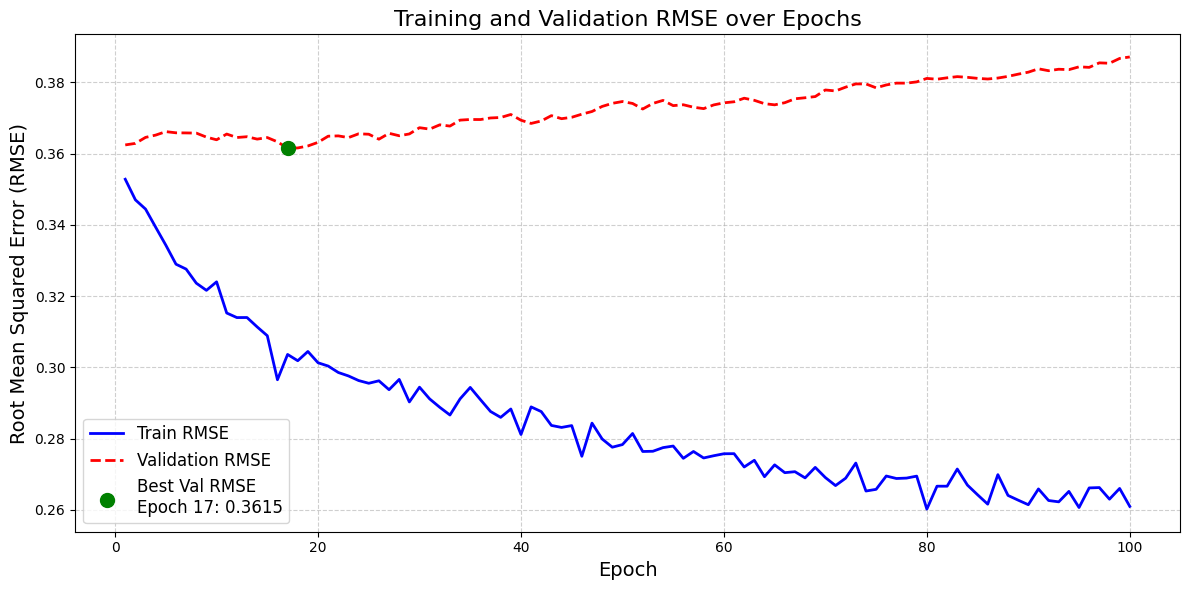

In [204]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil data RMSE dari history
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']
epochs = range(1, len(train_rmse) + 1)

plt.figure(figsize=(12, 6))

# Plot train RMSE
plt.plot(epochs, train_rmse, 'b-', label='Train RMSE', linewidth=2)

# Plot validation RMSE
plt.plot(epochs, val_rmse, 'r--', label='Validation RMSE', linewidth=2)

# Titik terbaik validation RMSE (epoch dengan nilai val RMSE terkecil)
best_epoch = np.argmin(val_rmse) + 1
best_val_rmse = val_rmse[best_epoch - 1]

plt.scatter(best_epoch, best_val_rmse, color='green', s=100, zorder=5,
            label=f'Best Val RMSE\nEpoch {best_epoch}: {best_val_rmse:.4f}')

plt.title('Training and Validation RMSE over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Penjelasan grafik plot :
- Garis biru solid = RMSE training

- Garis merah putus-putus = RMSE validasi

- Titik hijau menandai epoch terbaik berdasarkan validasi RMSE (nilai terendah)

- Plot menunjukkan bahwa nilai RMSE training dan validasi cukup dekat dan stabil, menandakan model tidak overfitting atau underfitting parah.
- `Best Epoch` berdasarkan Val RMSE adalah Epoch ke 11

In [205]:
resto_df = data_tourism_with_id
df = data_tourism_rating

# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
resto_visited_by_user = df[df.User_Id == user_id]

In [206]:
resto_not_visited = resto_df[~resto_df['Place_Id'].isin(resto_visited_by_user.Place_Id.values)]['Place_Id']
resto_not_visited = list(
    set(resto_not_visited)
    .intersection(set(resto_to_resto_encoded.keys()))
)

resto_not_visited = [[resto_to_resto_encoded.get(x)] for x in resto_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_resto_array = np.hstack(
    ([[user_encoder]] * len(resto_not_visited), resto_not_visited)
)

In [207]:
ratings = model.predict(user_resto_array).flatten()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


In [208]:
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_resto_ids = [
    resto_encoded_to_resto.get(resto_not_visited[x][0]) for x in top_ratings_indices
]

In [215]:
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Resto with high ratings from user')
print('----' * 8)

top_resto_user = (
    resto_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(10)
    .Place_Id.values
)

resto_df_rows = resto_df[resto_df['Place_Id'].isin(top_resto_user)]
for row in resto_df_rows.itertuples():
    print(row.Place_Name)

print('----' * 8)
print('Top 10 resto recommendation')
print('----' * 8)

recommended_resto = resto_df[resto_df['Place_Id'].isin(recommended_resto_ids)]
for row in recommended_resto.itertuples():
    print(row.Place_Name)

Showing recommendations for users: 163
Resto with high ratings from user
--------------------------------
Taman Menteng
Sumur Gumuling
Embung Tambakboyo
Gumuk Pasir Parangkusumo
Bendung Lepen
Museum Gunung Merapi
Museum Gedung Sate
Bukit Jamur
Taman Pandanaran
Surabaya North Quay
--------------------------------
Top 10 resto recommendation
--------------------------------
Taman Prestasi
Taman Pelangi
Taman Keputran
Taman Ekspresi Dan Perpustakaan
Rumah Batik
Masjid Nasional Al-Akbar
Keraton Surabaya
Surabaya Museum (Gedung Siola)
Monumen Jalesveva Jayamahe
Waterpark Kenjeran Surabaya


In [210]:
def get_bulk_recommendations(model, user_ids, user_encoder, item_encoder, item_decoder, user_item_df, item_df, top_k=10):
    """
    Fungsi rekomendasi top_k item untuk banyak user sekaligus.

    Args:
    - model: trained keras model (RecommenderNet)
    - user_ids: list/array user_id asli (misal semua user dalam dataset)
    - user_encoder: dict mapping user_id ke encoded index
    - item_encoder: dict mapping item_id ke encoded index
    - item_decoder: dict mapping encoded index ke item_id
    - user_item_df: DataFrame rating dengan kolom ['User_Id','Place_Id','Place_Ratings']
    - item_df: DataFrame item lengkap (nama, id, dll)
    - top_k: jumlah rekomendasi per user

    Returns:
    - dict: {user_id: [list rekomendasi nama item]}
    """

    all_recommendations = {}

    for user_id in user_ids:
        if user_id not in user_encoder:
            all_recommendations[user_id] = []
            continue

        visited = user_item_df[user_item_df['User_Id'] == user_id]['Place_Id'].values
        not_visited = item_df[~item_df['Place_Id'].isin(visited)]['Place_Id']
        not_visited = list(set(not_visited).intersection(set(item_encoder.keys())))

        if len(not_visited) == 0:
            all_recommendations[user_id] = []
            continue

        user_encoded = user_encoder[user_id]
        not_visited_encoded = [[item_encoder[x]] for x in not_visited]

        user_input = np.hstack((np.array([[user_encoded]] * len(not_visited_encoded)), not_visited_encoded))

        preds = model.predict(user_input).flatten()
        top_indices = preds.argsort()[-top_k:][::-1]

        recommended_ids = [not_visited[i] for i in top_indices]
        recommended_names = item_df[item_df['Place_Id'].isin(recommended_ids)]['Place_Name'].values

        all_recommendations[user_id] = recommended_names.tolist()

    return all_recommendations


In [214]:
all_users = data_collaborative_filtering['User_Id'].unique()

bulk_rekom = get_bulk_recommendations(
    model=model,
    user_ids=all_users,
    user_encoder=user_to_user_encoded,
    item_encoder=resto_to_resto_encoded,
    item_decoder=resto_encoded_to_resto,
    user_item_df=data_collaborative_filtering,
    item_df=data_tourism_with_id,
    top_k=10
)

# Contoh print rekomendasi user pertama
first_user = all_users[0]
print('----------------------------------------')
print(f"Rekomendasi untuk user {first_user}:")
print('----------------------------------------')
print(bulk_rekom[first_user])


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step 
2/2 ━━━━

In [212]:
def get_recommendations_for_user(model, user_id, user_encoder, item_encoder, item_decoder, user_item_df, item_df, top_k=10):
    """
    Fungsi untuk rekomendasi top_k item (tempat wisata) untuk user tertentu.

    Args:
    - model: trained keras model (RecommenderNet)
    - user_id: id asli user (misal 'User_Id')
    - user_encoder: dict mapping user_id ke encoded index
    - item_encoder: dict mapping item_id (Place_Id) ke encoded index
    - item_decoder: dict mapping encoded index ke item_id (Place_Id)
    - user_item_df: DataFrame rating dengan kolom ['User_Id','Place_Id','Place_Ratings']
    - item_df: DataFrame item (tempat wisata) lengkap, untuk ambil nama dsb
    - top_k: jumlah rekomendasi yang diinginkan (default=10)

    Returns:
    - List nama item yang direkomendasikan
    """

    if user_id not in user_encoder:
        return f"User ID {user_id} tidak ditemukan dalam data."

    # Tempat yang sudah pernah dikunjungi user
    visited = user_item_df[user_item_df['User_Id'] == user_id]['Place_Id'].values

    # Tempat yang belum dikunjungi
    not_visited = item_df[~item_df['Place_Id'].isin(visited)]['Place_Id']
    not_visited = list(set(not_visited).intersection(set(item_encoder.keys())))

    # Encode user dan tempat yang belum dikunjungi
    user_encoded = user_encoder[user_id]
    not_visited_encoded = [[item_encoder[x]] for x in not_visited]

    # Bentuk array input untuk model
    user_input = np.hstack((np.array([[user_encoded]] * len(not_visited_encoded)), not_visited_encoded))

    # Prediksi rating untuk tempat belum dikunjungi
    preds = model.predict(user_input).flatten()

    # Urutkan indeks rating tertinggi
    top_indices = preds.argsort()[-top_k:][::-1]

    # Decode item_id rekomendasi
    recommended_ids = [not_visited[i] for i in top_indices]

    # Ambil nama tempat dari item_df
    recommended_names = item_df[item_df['Place_Id'].isin(recommended_ids)]['Place_Name'].values

    return recommended_names.tolist()


In [213]:
recommendations = get_recommendations_for_user(
    model=model,
    user_id=123,
    user_encoder=user_to_user_encoded,
    item_encoder=resto_to_resto_encoded,
    item_decoder=resto_encoded_to_resto,
    user_item_df=data_collaborative_filtering,
    item_df=data_tourism_with_id,
    top_k=10
)
print('-----------------------------------------------------')
print("Tempat Top 10 Rekomendasi untuk user dengan ID 123:")
print('-----------------------------------------------------')
for place in recommendations:
    print(place)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
-----------------------------------------------------
Tempat Top 10 Rekomendasi untuk user dengan ID 123:
-----------------------------------------------------
Taman Pelangi
Taman Keputran
Masjid Nasional Al-Akbar
Keraton Surabaya
Surabaya Museum (Gedung Siola)
Monumen Jalesveva Jayamahe
Waterpark Kenjeran Surabaya
Taman Hiburan Rakyat
Museum Mpu Tantular
Gereja Perawan Maria Tak Berdosa Surabaya


**Berhasil Membuat Rekomendasi**
- Untuk user tertentu, model memprediksi rating untuk semua tempat yang belum dikunjungi.
- Tempat dengan prediksi rating tertinggi direkomendasikan ke user tersebut.



**Keunggulan Collaborative Filtering**
- Menangkap preferensi tersembunyi dari pola rating banyak pengguna tanpa perlu data atribut item (deskripsi, kategori).
- Dapat memberikan rekomendasi personal yang adaptif mengikuti perilaku dan selera pengguna.
- Bisa merekomendasikan item yang berbeda jauh dari yang sudah pernah user lihat (eksplorasi).

**Keterbatasan**
- Membutuhkan data interaksi (rating) yang cukup banyak agar model efektif.
- Cold start problem untuk user atau item baru yang belum punya data rating.
- Model perlu pelatihan ulang jika data rating baru masuk.

## 7. Conclusion



Sistem rekomendasi destinasi wisata Kota Surabaya **berhasil** dikembangkan menggunakan metode **Content-Based Filtering** dan **Collaborative Filtering** berbasis deep learning.

* Melalui eksplorasi data dan preprocessing yang tepat, model menunjukkan performa yang stabil dan akurat berdasarkan metrik Root Mean Squared Error (RMSE) pada data training dan validasi.

* Visualisasi data dan hasil rekomendasi memperkuat pemahaman tentang karakteristik pengguna dan destinasi wisata, serta memberikan insight yang berguna untuk pengembangan pariwisata di Surabaya.

* **Content-Based Filtering** mampu memberikan rekomendasi berdasarkan kemiripan deskripsi dan kategori tempat wisata, sehingga membantu pengguna menemukan tempat baru yang serupa dengan preferensi mereka.

* **Collaborative Filtering** dengan model neural network embedding berhasil menangkap pola interaksi antara pengguna dan destinasi wisata melalui data rating, menghasilkan rekomendasi yang personal dan adaptif.
